In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import datetime
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import warnings
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

In [2]:
store = pd.read_csv("./data/store.csv")
train = pd.read_csv("./data/train.csv",parse_dates=[2])
test = pd.read_csv("./data/test.csv",parse_dates=[3])
state = pd.read_csv("./data/store_states.csv")

#https://kb.bullseyelocations.com/support/solutions/articles/5000544642-germany-state-codes
weather_BW = pd.read_csv("./data/weather/BadenWÃ¼rttemberg.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_BW['State'] = 'BW'
weather_BY = pd.read_csv("./data/weather/Bayern.csv", parse_dates=[0], sep = ';')
weather_BY['State'] = 'BY'
weather_BE = pd.read_csv("./data/weather/Berlin.csv", parse_dates=[0], sep = ';')
weather_BE['State'] = 'BE'
#weather_BB = pd.read_csv("./data/weather/Brandenburg.csv", parse_dates=[1])
weather_HB = pd.read_csv("./data/weather/Bremen.csv", parse_dates=[0], sep = ';')
weather_HB['State'] = 'HB'
weather_HH = pd.read_csv("./data/weather/Hamburg.csv", parse_dates=[0], sep = ';')
weather_HH['State'] = 'HH'
weather_HE = pd.read_csv("./data/weather/Hessen.csv", parse_dates=[0], sep = ';')
weather_HE['State'] = 'HE'
#weather_MV = pd.read_csv("./data/weather/MecklenburgVorpommern.csv", parse_dates=[1])
weather_NW = pd.read_csv("./data/weather/NordrheinWestfalen.csv", parse_dates=[0], sep = ';')
weather_NW['State'] = 'NW'
weather_RP = pd.read_csv("./data/weather/RheinlandPfalz.csv", parse_dates=[0], sep = ';')
weather_RP['State'] = 'RP'
#weather_SL = pd.read_csv("./data/weather/Saarland.csv", parse_dates=[1])
weather_SN = pd.read_csv("./data/weather/Sachsen.csv", parse_dates=[0], sep = ';')
weather_SN['State'] = 'SN'
weather_ST = pd.read_csv("./data/weather/SachsenAnhalt.csv", parse_dates=[0], sep = ';')
weather_ST['State'] = 'ST'
weather_SH = pd.read_csv("./data/weather/SchleswigHolstein.csv", parse_dates=[0], sep = ';')
weather_SH['State'] = 'SH'
weather_TH = pd.read_csv("./data/weather/ThÃ¼ringen.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_TH['State'] = 'TH'

weather_combined = pd.concat([weather_BW,weather_BY,weather_BE,weather_HB,weather_HH,weather_HE,
                             weather_NW,weather_RP,weather_SN,weather_ST,weather_SH,weather_TH])

weather_combined.Events = weather_combined.Events.fillna('Normal')
weather_combined = weather_combined[['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
                               'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State']]
# fill missing values in test with 1
test.fillna(value = 1, inplace = True)

In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# check store nan rows
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [5]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [54]:
state['State'].unique()

array(['HE', 'TH', 'NW', 'BE', 'SN', 'SH', 'HB,NI', 'BY', 'BW', 'RP',
       'ST', 'HH'], dtype=object)

In [8]:
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [9]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [11]:
np.sum([train['Sales'] == 0])

172871

In [13]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [14]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [16]:
# check missing values in test open column
test[test.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [100]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [102]:
train.StoreType.unique()

array(['a', 'c', 'd', 'b'], dtype=object)

In [103]:
train.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [103]:
weather_combined.columns

Index(['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Precipitationmm',
       'Events', 'State'],
      dtype='object')

In [4]:
#Changing stores where state could not be unqiuely identified to HH due to geographical proximity
state.loc[state['State']=='HB,NI', 'State']='HH'
store = store.merge(state, on = 'Store', how = 'left', suffixes=(False, False))
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

train = train.sort_values(['Date'],ascending = False)
train_full = train.copy()

# split the last 6 weeks data as validation set, just like our test dataset
#As per https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# Using only those datapoints where Sales>0 and Open is 1
# There is not point predicting 0 sales

train = train[(train.Open != 0)&(train.Sales >0)]
train = train.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
valid = valid.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
train_full = train_full[(train_full.Open != 0)&(train_full.Sales >0)]
train_full = train_full.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
train_test_merged = pd.concat([train_full.sort_values('Date'), test.sort_values('Date')], axis = 0)
test = test.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))

In [98]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [5]:
# process train and test
def preprocessprocess_data(data, isTest = False, isMerged = False, isFull = True):
    
    # label encoding 
    #https://www.kaggle.com/danspace/rossmann-store-sales-xgboost
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    store_mapping = {'NW':1, 'HE':2, 'BY':3, 'RP':4, 'BE':5, 'SN':6, 'ST':7, 'BW':8, 'SH':9, 'HH':10, 'TH':11}
    weather_event_mapping = {'Fog':1, 'Normal':2, 'Rain':3, 'Rain-Thunderstorm':4, 'Fog-Rain':5,
                           'Rain-Hail-Thunderstorm':6, 'Fog-Rain-Thunderstorm':7, 'Thunderstorm':8,
                           'Rain-Hail':9, 'Fog-Thunderstorm':10, 'Rain-Snow':11,
                           'Fog-Rain-Hail-Thunderstorm':12, 'Snow':13, 'Rain-Snow-Hail':14,
                           'Rain-Snow-Thunderstorm':15, 'Rain-Snow-Hail-Thunderstorm':16,
                           'Fog-Rain-Snow':17, 'Fog-Snow':18, 'Snow-Hail':19, 'Fog-Rain-Snow-Hail':20,
                           'Fog-Rain-Hail':21, 'Fog-Snow-Hail':22
                            }
    
    data.StoreType.to_string()
    data.StateHoliday.to_string()
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data.State.replace(store_mapping, inplace=True)
    data.Events.replace(weather_event_mapping, inplace=True)
    
    # extract some features from date column  
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpenInMonths'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpenInMonths'] = data['CompetitionOpenInMonths'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['Promo2OpenInMonths'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['Promo2OpenInMonths'] = data['Promo2OpenInMonths'].apply(lambda x:x if x>0 else 0)
    
    data['CompetitionOpenSinceYear'].fillna(0, inplace = True)
    data['CompetitionOpenSinceMonth'].fillna(0, inplace = True)
    data['Promo2SinceYear'].fillna(0, inplace = True)
    data['Promo2SinceWeek'].fillna(0, inplace = True)
    data['CompetitionDistance'].fillna(0, inplace = True)

    month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month_dict)

    def check_promo_month(row):
        '''Indicate whether the month is in promo interval'''
        if isinstance(row['PromoInterval'],str) and (row['month_str'] in row['PromoInterval']) \
        and (row['Promo2OpenInMonths']>0):
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check_promo_month(row),axis=1)    
    
    def get_prev_sales(data):
        '''Returns dataframe with previous sales values, simple moving averages, exponentially weighted MA'''
        #https://towardsdatascience.com/timeseries-data-munging-lagging-variables-that-are-distributed-across-multiple-groups-86e0a038460c
        #https://stackoverflow.com/questions/61234837/pandas-panel-data-shifting-values-by-two-taking-into-consideration-year-gaps
    
        df = data.set_index(['Date', 'Store']).sort_values('Date')
        #new_column = df.groupby('Store')['Sales'].shift(30)
        #df['Sales_30'] = new_column
        #df.reset_index(inplace=True)

        #Getting 60 days lagging sales for that particular store
        new_column = df.groupby('Store')['Sales'].shift(60)
        df['Sales_60'] = new_column
        df.reset_index(inplace=True)

        #Getting 90 days lagging sales for that particular store
        new_column = df.groupby('Store')['Sales'].shift(90)
        df['Sales_90'] = new_column

        #Getting 180 days lagging sales for that particular store
        new_column = df.groupby('Store')['Sales'].shift(180)
        df['Sales_180'] = new_column

        #Getting 365 days lagging sales for that particular store
        new_column = df.groupby('Store')['Sales'].shift(365)
        df['Sales_1year'] = new_column
            
        #df = df.sort_values('Date')
        #https://stackoverflow.com/questions/48967165/using-shift-and-rolling-in-pandas-with-groupby
        df['MA_15'] = df['Sales_60'].groupby(df['Store'], group_keys=False).rolling(15).mean()
        df['MA_30'] = df['Sales_60'].groupby(df['Store'], group_keys=False).rolling(30).mean()
            
        #https://stackoverflow.com/questions/58002668/pandas-groupby-ewm
        df['EWM_15'] = df.groupby(['Store'])['Sales_60'].transform(lambda x: x.ewm(span = 15, min_periods = 15).mean()).values
        df['EWM_30'] = df.groupby(['Store'])['Sales_60'].transform(lambda x: x.ewm(span = 30, min_periods = 30).mean()).values
        df['EWM_45'] = df.groupby(['Store'])['Sales_60'].transform(lambda x: x.ewm(span = 45, min_periods = 45).mean()).values
        
        return df
    
    features = ['Store', 'Date', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
           'WeekOfYear', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',
           'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek',
           'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
           'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State']
    
    if not isTest:
        data =  get_prev_sales(data)
        features = ['Store', 'Date', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
           'WeekOfYear', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek',
            'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15',
            'EWM_30', 'EWM_45', 'Sales', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
           'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State'
            ]
    
    if isMerged:

        #Number of school holidays in a week for a particular store
        def get_noof_school_holidays(x):
            if x.sum()>6:
                return 6
            else:
                return x.sum()
        
        data['StateHolidayBinary'] = data['StateHoliday'].apply(lambda x:0 if x==0 else 1)
        
        #Number of School Holidays in last 7 days
        data['SchoolHolidaysInPrevWeek'] = data.groupby(['Store'])['SchoolHoliday'].transform(lambda x:x.rolling(7).sum()).values

        #Number of School Holidays in current week
        data['SchoolHolidaysInWeek'] = data.groupby(['Year','WeekOfYear','Store'])['SchoolHoliday'].transform(get_noof_school_holidays).values

        #Number of State Holidays in last 7 days
        data['StateHolidaysInPrevWeek'] = data.groupby(['Store'])['StateHolidayBinary'].transform(lambda x:x.rolling(7).sum()).values

        #Number of state holidays in current week for a particular store
        data['StateHolidaysInWeek'] = data.groupby(['Year','WeekOfYear','Store'])['StateHolidayBinary'].transform(sum).values


        data = data.sort_values('Date', ascending= False)

        #Number of School Holidays in next 7 days
        data['SchoolHolidaysInNextWeek'] = data.groupby('Store', group_keys=False)\
                                                    ['SchoolHoliday'].transform(lambda x:x.rolling(7).sum())
        #Number of State Holidays in next 7 days
        data['StateHolidaysInNextWeek'] = data.groupby('Store', group_keys=False)\
                                                    ['StateHolidayBinary'].transform(lambda x:x.rolling(7).sum())
        
        if not isFull:
            #Getting starting date of summer holiday
            data['SummerHolidayStart'] = data.set_index('Date').groupby(['Store','Year'])\
                        ['SchoolHoliday'].transform(lambda x:x.rolling(20).sum().idxmax()).values

            data = data.sort_values('Date')
            #Getting the ending date for summer holiday
            data['SummerHolidayEnd'] = data.set_index('Date').groupby(['Store','Year'])\
                        ['SchoolHoliday'].transform(lambda x:x.rolling(20).sum().idxmax()).values
            
        #Getting starting date of summer holiday
        data['SummerHolidayStart'] = data.set_index('Date').groupby(['Store','Year'])\
                    ['SchoolHoliday'].transform(lambda x:x.rolling(40).sum().idxmax()).values
        
        data = data.sort_values('Date')
        #Getting the ending date for summer holiday
        data['SummerHolidayEnd'] = data.set_index('Date').groupby(['Store','Year'])\
                    ['SchoolHoliday'].transform(lambda x:x.rolling(40).sum().idxmax()).values
        
        #Variable to indicate if summer holiday is going on
        data['SummerHoliday'] = data[['SummerHolidayEnd', 'SummerHolidayStart', 'Date','Month']].apply\
                        (lambda x:1 if x[2]<=x[0] and x[2]>=x[1] and x[3]>=6 and x[3]<= 9 else 0, axis = 1)
        
        
        features = ['Store', 'Date', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
           'WeekOfYear', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek',
            'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15',
            'EWM_30', 'EWM_45', 'Sales','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
            'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
            'StateHolidaysInNextWeek', 'SummerHoliday', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
           'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State'
            ]

    data = data[features]
    return data

    
train_cl = preprocessprocess_data(train)
valid_cl = preprocessprocess_data(valid)
train_full_cl = preprocessprocess_data(train_full, isMerged = True, isFull = False)
train_test_cl = preprocessprocess_data(train_test_merged, isMerged = True)

#For merging train with combined data to get the holidays data
train_full_select = train_full_cl.drop('Sales', axis=1)[['Date', 'Store','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
                        'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
                        'StateHolidaysInNextWeek', 'SummerHoliday'
                        ]]

train_cl = train_cl.merge(train_full_select, on=['Date', 'Store'], how = 'inner')

#For merging validation with combined data to get the holidays data
valid_cl = valid_cl.merge(train_full_select, on=['Date', 'Store'], how = 'inner')

#Getting the full training data
train_full_cl = train_test_cl.iloc[:-41088,:]

test_cl = preprocessprocess_data(test, isTest = True)

#Merging previous sales and holiday features obtained from combined data
train_test_select = train_test_cl.drop('Sales', axis=1)[['Date', 'Store','Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15',
                         'MA_30', 'EWM_15', 'EWM_30', 'EWM_45', 'SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
                        'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
                        'StateHolidaysInNextWeek', 'SummerHoliday']]

test_cl = test_cl.merge(train_test_select, on=['Date', 'Store'], how = 'left', suffixes=(False, False))
test_cl = test_cl.sort_values('Date')



In [83]:
#pickle.dump((train_cl),open('train_int.pkl','wb'))
#pickle.dump((train_full_cl),open('train_full_int.pkl','wb'))
#pickle.dump((valid_cl),open('valid_int.pkl','wb'))
#pickle.dump((test_cl),open('test_int.pkl','wb'))

train_cl = pickle.load(open("train_int.pkl", 'rb'))
train_full_cl = pickle.load(open("train_full_int.pkl", 'rb'))
valid_cl = pickle.load(open("valid_int.pkl", 'rb'))
test_cl = pickle.load(open("test_int.pkl", 'rb'))

In [84]:
scnxtweek_mode = train_cl.SchoolHolidaysInNextWeek.mode()[0]
train_cl.Events.fillna(scnxtweek_mode, inplace=True)
valid_cl.SchoolHolidaysInNextWeek.fillna(scnxtweek_mode, inplace=True)
train_full_scnxtweek_mode = train_full_cl.SchoolHolidaysInNextWeek.mode()[0]
train_full_cl.SchoolHolidaysInNextWeek.fillna(train_full_scnxtweek_mode, inplace=True)
test_cl.SchoolHolidaysInNextWeek.fillna(train_full_scnxtweek_mode, inplace=True)

stnxtweek_mode = train_cl.StateHolidaysInNextWeek.mode()[0]
train_cl.StateHolidaysInNextWeek.fillna(stnxtweek_mode, inplace=True)
valid_cl.StateHolidaysInNextWeek.fillna(stnxtweek_mode, inplace=True)
train_full_stnxtweek_mode = train_full_cl.StateHolidaysInNextWeek.mode()[0]
train_full_cl.StateHolidaysInNextWeek.fillna(train_full_stnxtweek_mode, inplace=True)
test_cl.StateHolidaysInNextWeek.fillna(train_full_stnxtweek_mode, inplace=True)

scprevweek_mode = train_cl.SchoolHolidaysInPrevWeek.dropna().mode()[0]
train_cl.SchoolHolidaysInPrevWeek.fillna(scprevweek_mode, inplace=True)
#valid.SchoolHolidaysInPrevWeek.fillna(stnxtweek_mode, inplace=True)
train_full_scprevweek_mode = train_full_cl.SchoolHolidaysInPrevWeek.dropna().mode()[0]
train_full_cl.SchoolHolidaysInPrevWeek.fillna(train_full_scprevweek_mode, inplace=True)
#test_cl.SchoolHolidaysInPrevWeek.fillna(train_full_stnxtweek_mode, inplace=True)


stprevweek_mode = train_cl.StateHolidaysInPrevWeek.dropna().mode()[0]
train_cl.StateHolidaysInPrevWeek.fillna(stprevweek_mode, inplace=True)
#valid.SchoolHolidaysInPrevWeek.fillna(stnxtweek_mode, inplace=True)
train_full_stprevweek_mode = train_full_cl.StateHolidaysInPrevWeek.dropna().mode()[0]
train_full_cl.StateHolidaysInPrevWeek.fillna(train_full_stprevweek_mode, inplace=True)
#test_cl.SchoolHolidaysInPrevWeek.fillna(train_full_stnxtweek_mode, inplace=True)

def customImputer(train_cl, valid_cl):    
    '''Imputes missing values by multiple linear regression method'''
    
    features = ['Store', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                'CompetitionDistance', 'Promo2', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',  
                'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15',
                'EWM_30', 'EWM_45','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
                'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
                'StateHolidaysInNextWeek', 'SummerHoliday', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
               'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State'
                ]
    #Removing any feature having more than 50% missing values
    for feat in features:
        missing_val = train_cl[feat].isna().sum()*100/len(train_cl)
        if missing_val>50:
            features.remove(feat)
            train_cl.drop(feat, axis = 1, inplace = True)
            valid_cl.drop(feat, axis = 1, inplace = True)
    while(train_cl[features].isna().any().any()):
        #Choosing the column with maximum missing values
        target_index = np.argmax(train_cl[features].isna().sum()/len(train_cl))
        target_col = features[target_index]
        #Setting that columns as target column
        y = train_cl[features][target_col]
        y_val = valid_cl[features][target_col]
        #Training on those indices without missing values
        y_tr = y[~y.isna()]
        #Predicting those indices which have missing values
        y_te = y[y.isna()]
        y_val_te = y_val[y_val.isna()]
        features.pop(target_index)
        #Getting the dependent variables
        X = train_cl[features]
        X_val = valid_cl[features]
        X = X.fillna(X.mean())
        X_val = X_val.fillna(X.mean())
        #Getting the train and test set
        X_tr = X[~y.isna()]
        X_te = X[y.isna()]
        X_val_te = X_val[y_val.isna()]
        #Using linear regression for imputation
        lin_reg = LinearRegression()
        lin_reg.fit(X_tr, y_tr)
        #Predicting the missing values
        y_te = lin_reg.predict(X_te)
        #Replacing the NA values with our predictions
        train_cl.loc[train_cl[target_col].isna(),target_col] = y_te
        if len(X_val_te)>0:
            y_val_te = lin_reg.predict(X_val_te)    
            valid_cl.loc[valid_cl[target_col].isna(),target_col] = y_val_te
    return train_cl, valid_cl

train_cl, valid_cl = customImputer(train_cl, valid_cl)
train_full_cl, test_cl = customImputer(train_full_cl, test_cl)

def get_final_data_new(train_cl, train_full_cl, valid_cl, test_cl):    
    train_cl['LogCompetitionDistance'] = train_cl.CompetitionDistance.apply(np.log1p)
    valid_cl['LogCompetitionDistance'] = valid_cl.CompetitionDistance.apply(np.log1p)
    train_full_cl['LogCompetitionDistance'] = train_full_cl.CompetitionDistance.apply(np.log1p)
    test_cl['LogCompetitionDistance'] = test_cl.CompetitionDistance.apply(np.log1p)
    test_cl = test_cl.sort_values(['Date', 'Store'], ascending = [0,1])

    num_columns = ['LogCompetitionDistance', 'CompetitionOpenInMonths', 'Promo2OpenInMonths',
                   'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek', 
                   'Sales_60', 'Sales_90', 'Sales_180', 'MA_15', 'MA_30', 'EWM_15',
                    'EWM_30', 'EWM_45','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
                    'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
                    'StateHolidaysInNextWeek', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
                    'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm']

    for num_feature in num_columns:
        min_max_scaler = MinMaxScaler()
        train_cl[num_feature] = min_max_scaler.fit_transform(train_cl[num_feature].values.reshape(-1,1))
        valid_cl[num_feature] = min_max_scaler.transform(valid_cl[num_feature].values.reshape(-1,1))

        min_max_scaler = MinMaxScaler()
        train_full_cl[num_feature] = min_max_scaler.fit_transform(train_full_cl[num_feature].values.reshape(-1,1))
        test_cl[num_feature] = min_max_scaler.transform(test_cl[num_feature].values.reshape(-1,1))
    
    y_train = train_cl.Sales.values
    y_train_full = train_full_cl.Sales.values
    y_valid = valid_cl.Sales.values
    
    X_train = train_cl.drop(['Sales', 'Date'], axis=1)
    X_train_full = train_full_cl.drop(['Sales', 'Date'], axis=1)
    X_valid = valid_cl.drop(['Sales', 'Date'], axis = 1)
    X_test = test_cl.drop('Date', axis = 1)
    
    return X_train , X_train_full, X_valid, X_test, y_train , y_train_full, y_valid

X_train , X_train_full, X_valid, X_test, y_train , y_train_full, y_valid = \
                                get_final_data_new(train_cl, train_full_cl, valid_cl, test_cl)

In [13]:
def missing_value_treatment(train_cl, train_full_cl, valid_cl, test_cl):
    scnxtweek_mode = train_cl.SchoolHolidaysInNextWeek.mode()[0]
    train_cl.Events.fillna(scnxtweek_mode, inplace=True)
    valid_cl.SchoolHolidaysInNextWeek.fillna(scnxtweek_mode, inplace=True)
    train_full_scnxtweek_mode = train_full_cl.SchoolHolidaysInNextWeek.mode()[0]
    train_full_cl.SchoolHolidaysInNextWeek.fillna(train_full_scnxtweek_mode, inplace=True)
    test_cl.SchoolHolidaysInNextWeek.fillna(train_full_scnxtweek_mode, inplace=True)

    stnxtweek_mode = train_cl.StateHolidaysInNextWeek.mode()[0]
    train_cl.StateHolidaysInNextWeek.fillna(stnxtweek_mode, inplace=True)
    valid_cl.StateHolidaysInNextWeek.fillna(stnxtweek_mode, inplace=True)
    train_full_stnxtweek_mode = train_full_cl.StateHolidaysInNextWeek.mode()[0]
    train_full_cl.StateHolidaysInNextWeek.fillna(train_full_stnxtweek_mode, inplace=True)
    test_cl.StateHolidaysInNextWeek.fillna(train_full_stnxtweek_mode, inplace=True)

    scprevweek_mode = train_cl.SchoolHolidaysInPrevWeek.dropna().mode()[0]
    train_cl.SchoolHolidaysInPrevWeek.fillna(scprevweek_mode, inplace=True)
    #valid.SchoolHolidaysInPrevWeek.fillna(stnxtweek_mode, inplace=True)
    train_full_scprevweek_mode = train_full_cl.SchoolHolidaysInPrevWeek.dropna().mode()[0]
    train_full_cl.SchoolHolidaysInPrevWeek.fillna(train_full_scprevweek_mode, inplace=True)
    #test_cl.SchoolHolidaysInPrevWeek.fillna(train_full_stnxtweek_mode, inplace=True)


    stprevweek_mode = train_cl.StateHolidaysInPrevWeek.dropna().mode()[0]
    train_cl.StateHolidaysInPrevWeek.fillna(stprevweek_mode, inplace=True)
    #valid.SchoolHolidaysInPrevWeek.fillna(stnxtweek_mode, inplace=True)
    train_full_stprevweek_mode = train_full_cl.StateHolidaysInPrevWeek.dropna().mode()[0]
    train_full_cl.StateHolidaysInPrevWeek.fillna(train_full_stprevweek_mode, inplace=True)
    #test_cl.SchoolHolidaysInPrevWeek.fillna(train_full_stnxtweek_mode, inplace=True)
    
    features = ['Store', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'CompetitionDistance', 'Promo2', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',  
            'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15',
            'EWM_30', 'EWM_45','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
            'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
            'StateHolidaysInNextWeek', 'SummerHoliday', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
           'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State'
            ]
    
    y_train = train_cl.Sales
    y_valid = valid_cl.Sales
    train_cl[features] = train_cl[features].values.astype(float)
    valid_cl[features] = valid_cl[features].values.astype(float)
    imputer = IterativeImputer(random_state=0, n_nearest_features=5, sample_posterior= True, skip_complete = True, verbose = 1)
    train_fl = imputer.fit_transform(train_cl[features])
    valid_fl = imputer.transform(valid_cl[features])

    y_train_full = train_full_cl.Sales
    train_full_cl[features] = train_full_cl[features].values.astype(float)
    imputer = IterativeImputer(random_state=0, n_nearest_features=5, sample_posterior= True, skip_complete = True, verbose = 1)
    train_full_fl = imputer.fit_transform(train_full_cl[features])
    test_cl[features] = test_cl[features].values.astype(float)
    test_fl = imputer.transform(test_cl[features])
    return train_fl, y_train, valid_fl, y_valid, train_full_fl,y_train_full, test_fl,\
            features,train_cl, train_full_cl, valid_cl, test_cl

train_fl, y_train, valid_fl, y_valid, train_full_fl,y_train_full, test_fl, features,train_cl, train_full_cl, valid_cl, test_cl =\
    missing_value_treatment(train_cl, train_full_cl, valid_cl, test_cl)

def get_final_data(train_fl, valid_fl, train_full_fl, test_fl, features, train_cl, train_full_cl, valid_cl, test_cl):    
    cols = list(set(train_cl.columns)-set(features))
    train_filled = pd.DataFrame(train_fl, columns=features, index=train_cl.index)
    train_cl = pd.concat([train_cl[cols], train_filled], axis=1)
    train_cl['LogCompetitionDistance'] = train_cl.CompetitionDistance.apply(np.log1p)
    valid_filled = pd.DataFrame(valid_fl, columns=features, index=valid_cl.index)
    valid_cl = pd.concat([valid_cl[cols], valid_filled], axis=1)
    valid_cl['LogCompetitionDistance'] = valid_cl.CompetitionDistance.apply(np.log1p)
    train_full_filled = pd.DataFrame(train_full_fl, columns=features, index=train_full_cl.index)
    train_full_cl = pd.concat([train_full_cl[cols], train_full_filled], axis=1)
    train_full_cl['LogCompetitionDistance'] = train_full_cl.CompetitionDistance.apply(np.log1p)
    test_filled = pd.DataFrame(test_fl, columns=features, index=test_cl.index)
    cols.remove('Sales')
    test_cl = pd.concat([test_cl[cols], test_filled], axis=1)
    test_cl['LogCompetitionDistance'] = test_cl.CompetitionDistance.apply(np.log1p)
    test_cl = test_cl.sort_values(['Date', 'Store'], ascending = [0,1])

    num_columns = ['StateHoliday', 'SchoolHoliday', 'LogCompetitionDistance',
                   'CompetitionOpenInMonths', 'Promo2OpenInMonths',
                   'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek', 
                   'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15',
                    'EWM_30', 'EWM_45','SchoolHolidaysInWeek', 'SchoolHolidaysInPrevWeek',
                    'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
                    'StateHolidaysInNextWeek', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
                    'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm']

    for num_feature in num_columns:
        min_max_scaler = MinMaxScaler()
        train_cl[num_feature] = min_max_scaler.fit_transform(train_cl[num_feature].values.reshape(-1,1))
        valid_cl[num_feature] = min_max_scaler.transform(valid_cl[num_feature].values.reshape(-1,1))

        min_max_scaler = MinMaxScaler()
        train_full_cl[num_feature] = min_max_scaler.fit_transform(train_full_cl[num_feature].values.reshape(-1,1))
        test_cl[num_feature] = min_max_scaler.transform(test_cl[num_feature].values.reshape(-1,1))

    X_train = train_cl.drop(['Sales', 'Date'], axis=1)
    X_train_full = train_full_cl.drop(['Sales', 'Date'], axis=1)
    X_valid = valid_cl.drop(['Sales', 'Date'], axis = 1)
    X_test = test_cl.drop('Date', axis = 1)
    
    return X_train , X_train_full, X_valid, X_test

X_train , X_train_full, X_valid, X_test = get_final_data(train_fl, valid_fl, train_full_fl, test_fl, features,\
                                                        train_cl, train_full_cl, valid_cl, test_cl)

[IterativeImputer] Completing matrix with shape (804056, 34)
[IterativeImputer] Completing matrix with shape (40282, 34)
[IterativeImputer] Completing matrix with shape (844338, 34)
[IterativeImputer] Completing matrix with shape (41088, 34)


In [92]:
#pickle.dump((X_train, y_train),open('train_cl.pkl','wb'))
#pickle.dump((X_train_full, y_train_full),open('train_full_cl.pkl','wb'))
#pickle.dump((X_valid, y_valid),open('valid_cl.pkl','wb'))
#pickle.dump((X_test),open('test_cl.pkl','wb'))


X_train, y_train = pickle.load(open("train_cl.pkl", 'rb'))
X_train_full, y_train_full = pickle.load(open("train_full_cl.pkl", 'rb'))
X_valid, y_valid = pickle.load(open("valid_cl.pkl", 'rb'))
X_test = pickle.load(open("test_cl.pkl", 'rb'))

In [126]:
sel_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'LogCompetitionDistance',
       'StoreType', 'Assortment', 'Promo2', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpenInMonths', 'Promo2OpenInMonths', 'IsPromoMonth',
        'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek',
        'StateHolidaysInPrevWeek', 'StateHolidaysInWeek', 'SchoolHolidaysInNextWeek',
        'StateHolidaysInNextWeek', 'SummerHoliday', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
        'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State',
#        'Sales_60', 'Sales_90', 'Sales_180', 'Sales_1year', 'MA_15', 'MA_30', 'EWM_15','EWM_30', 'EWM_45'  
           ]
X_train_select = X_train[sel_cols]
X_valid_select = X_valid[sel_cols]
X_train_full_select = X_train_full[sel_cols]
X_test_select = X_test[sel_cols]

In [118]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = y.get_label()
    return "rmspe", rmspe(y,yhat)

**Ridge Regression**

In [111]:
ridge_regression = Ridge()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(ridge_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train_select, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    5.5s finished


In [112]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_alpha = results['param_alpha']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.666931,0.243262,0.064199,0.009952,1e-05,{'alpha': 1e-05},-1.098913,-0.136383,-0.137640,-0.457646,0.453445,7,-0.141028,-0.142302,-0.139554,-0.140961,0.001123
1,0.681796,0.227196,0.062732,0.019111,0.0001,{'alpha': 0.0001},-1.099491,-0.136292,-0.137609,-0.457797,0.453746,8,-0.141031,-0.142303,-0.139554,-0.140962,0.001123
2,0.537148,0.148206,0.063350,0.007600,0.001,{'alpha': 0.001},-1.103831,-0.135630,-0.137342,-0.458934,0.456011,9,-0.141196,-0.142334,-0.139559,-0.141030,0.001139
3,0.493558,0.169599,0.057735,0.007149,0.01,{'alpha': 0.01},-1.113545,-0.134427,-0.136493,-0.461488,0.461074,10,-0.142207,-0.142738,-0.139677,-0.141541,0.001336
4,0.492685,0.179849,0.056605,0.010426,0.1,{'alpha': 0.1},-1.114726,-0.134292,-0.136211,-0.461743,0.461730,11,-0.142717,-0.143118,-0.139890,-0.141908,0.001436


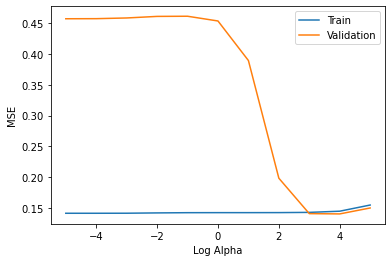

In [114]:
plt.plot(np.log10(param_alpha.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_alpha.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [127]:
ridge_regression = Ridge(alpha = 100)
ridge_regression.fit(X_train_select, np.log1p(y_train))

y_train_pred = ridge_regression.predict(X_train_select)  
y_valid_pred = ridge_regression.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

0.4639446506667063
0.41442279945638577


**Lasso Regression**

In [115]:
lasso_regression = Lasso()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(lasso_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train_select, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  1.9min finished


In [116]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_alpha = results['param_alpha']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,71.887215,30.925736,0.048400,0.009967,1e-05,{'alpha': 1e-05},-0.155176,-0.134284,-0.136211,-0.141890,0.009427,3,-0.142989,-0.143191,-0.139947,-0.142042,0.001484
1,79.528949,27.448561,0.052335,0.017285,0.0001,{'alpha': 0.0001},-0.150393,-0.134307,-0.136308,-0.140336,0.007158,2,-0.143100,-0.143285,-0.140030,-0.142138,0.001493
2,7.994707,3.420584,0.058066,0.001681,0.001,{'alpha': 0.001},-0.145462,-0.134483,-0.137834,-0.139260,0.004594,1,-0.144243,-0.143957,-0.140840,-0.143013,0.001541
3,1.216420,0.567960,0.058014,0.000860,0.01,{'alpha': 0.01},-0.150341,-0.137172,-0.143811,-0.143775,0.005376,4,-0.149694,-0.149605,-0.145227,-0.148175,0.002085
4,0.669105,0.241050,0.058240,0.001446,0.1,{'alpha': 0.1},-0.181919,-0.171845,-0.174970,-0.176245,0.004210,5,-0.181638,-0.181296,-0.177407,-0.180114,0.001919


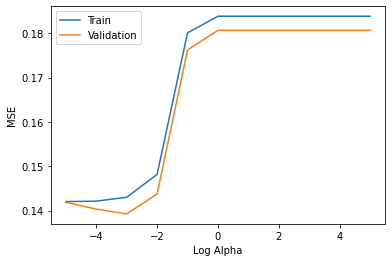

In [117]:
plt.plot(np.log10(param_alpha.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_alpha.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [133]:
lasso_regression = Lasso(alpha = 0.1)
lasso_regression.fit(X_train_select, np.log1p(y_train))

y_train_pred = lasso_regression.predict(X_train_select)  
y_valid_pred = lasso_regression.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

0.5488777357200697
0.5023569730580222


**Linear SVR**

In [134]:
svr_regression = LinearSVR()
parameters = {'C':[10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(svr_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train_select, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 25.3min finished


In [135]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_C = results['param_C']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,300.248891,143.941718,0.048519,0.001647,0.0001,{'C': 0.0001},-0.145906,-0.165924,-0.179892,-0.163907,0.013948,2,-0.145841,-0.181857,-0.169924,-0.165874,0.014980
1,306.434919,143.166349,0.047447,0.000550,0.001,{'C': 0.001},-0.262356,-0.158997,-0.310118,-0.243824,0.063071,8,-0.248845,-0.163485,-0.285802,-0.232711,0.051223
2,286.150583,122.281705,0.049477,0.002297,0.01,{'C': 0.01},-0.228469,-0.153799,-0.138404,-0.173557,0.039334,3,-0.238361,-0.167977,-0.143237,-0.183192,0.040297
3,299.625265,132.078222,0.056931,0.008392,0.1,{'C': 0.1},-0.197253,-0.135057,-0.620665,-0.317658,0.215758,9,-0.206412,-0.144263,-0.574964,-0.308546,0.190086
4,312.766039,143.093074,0.047385,0.000781,1,{'C': 1},-0.273330,-0.210055,-0.187303,-0.223563,0.036396,4,-0.290681,-0.228700,-0.176567,-0.231982,0.046645


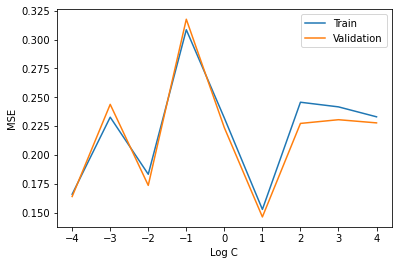

In [136]:
plt.plot(np.log10(param_C.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_C.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log C')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [141]:
svr_regression = LinearSVR(C = 0.01)
svr_regression.fit(X_train_select, np.log1p(y_train))

y_train_pred = svr_regression.predict(X_train_select)  
y_valid_pred = svr_regression.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

0.508371451201503
0.4382259987538666


**Decision Tree**

In [201]:
decision_tree = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=3)
parameters = {'min_samples_split':[100, 200, 500], 'max_depth':[10, 20, 30, 50]}
clf = GridSearchCV(decision_tree, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train_select, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   57.8s finished


In [202]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 100}

In [203]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_max_depth = results['param_max_depth']
param_min_samples_split = results['param_min_samples_split']
results.head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.661893,2.608102,0.083336,0.001124,10,100,"{'max_depth': 10, 'min_samples_split': 100}",-0.103522,-0.091707,-0.098123,-0.097784,0.004829,10,-0.087736,-0.092509,-0.088788,-0.089678,0.002048
1,5.648349,2.604774,0.082078,0.001486,10,200,"{'max_depth': 10, 'min_samples_split': 200}",-0.104670,-0.091752,-0.098390,-0.098271,0.005275,11,-0.088729,-0.093083,-0.089108,-0.090307,0.001969
2,5.502365,2.615622,0.066831,0.003439,10,500,"{'max_depth': 10, 'min_samples_split': 500}",-0.107936,-0.092930,-0.099281,-0.100049,0.006150,12,-0.093480,-0.095505,-0.090062,-0.093016,0.002246
3,8.725265,4.335923,0.095632,0.003929,20,100,"{'max_depth': 20, 'min_samples_split': 100}",-0.058668,-0.037780,-0.046716,-0.047721,0.008557,3,-0.028132,-0.025395,-0.025513,-0.026347,0.001263
4,8.337576,4.199635,0.085768,0.007063,20,200,"{'max_depth': 20, 'min_samples_split': 200}",-0.065056,-0.038743,-0.048913,-0.050904,0.010834,6,-0.038255,-0.032515,-0.029659,-0.033476,0.003575
5,7.748575,3.992382,0.080065,0.004256,20,500,"{'max_depth': 20, 'min_samples_split': 500}",-0.081286,-0.051720,-0.056190,-0.063065,0.013012,9,-0.060112,-0.048797,-0.038782,-0.049230,0.008714
6,9.174301,4.750818,0.100905,0.007918,30,100,"{'max_depth': 30, 'min_samples_split': 100}",-0.057905,-0.035981,-0.041419,-0.045102,0.009322,2,-0.026789,-0.022944,-0.018970,-0.022901,0.003192
7,8.636859,4.466988,0.090850,0.006306,30,200,"{'max_depth': 30, 'min_samples_split': 200}",-0.064163,-0.038998,-0.043610,-0.048924,0.010939,4,-0.037511,-0.030955,-0.024466,-0.030978,0.005325


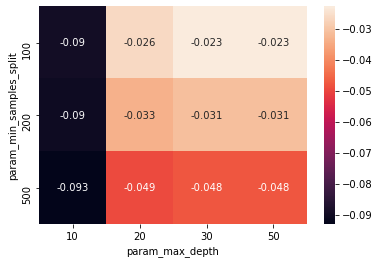

In [204]:
data_train = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_train_score')
sns.heatmap(data_train, annot=True)

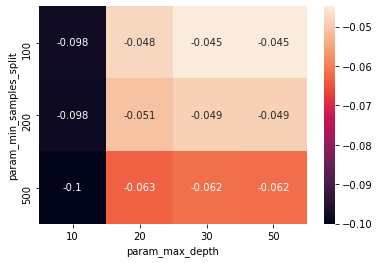

In [205]:
data_train = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
sns.heatmap(data_train, annot=True)

In [206]:
best_max_depth = 30
best_min_samples_split = 100

decision_tree = DecisionTreeRegressor(max_depth= best_max_depth, min_samples_split=best_min_samples_split)
decision_tree.fit(X_train_select, np.log1p(y_train))

y_train_pred = decision_tree.predict(X_train_select)  
y_valid_pred = decision_tree.predict(X_valid_select)

In [210]:
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

0.16942776295203074
0.16300194136827528


In [91]:
## Using Custom imputer ##
best_max_depth = 30
best_min_samples_split = 100

decision_tree = DecisionTreeRegressor(max_depth= best_max_depth, min_samples_split=best_min_samples_split)
decision_tree.fit(X_train_select, np.log1p(y_train))

y_train_pred = decision_tree.predict(X_train_select)  
y_valid_pred = decision_tree.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

0.16942776295203332
0.16275802598140793


**Random Forest**

In [6]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
lin_reg = RandomForestRegressor(max_features = 0.5)
parameters = {'max_depth':[10,20,30], 'n_estimators':[20,50,100]}

tscv = TimeSeriesSplit(n_splits=3)
clf = RandomizedSearchCV(lin_reg, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=2, return_train_score=True, n_iter=10, n_jobs = 2)
clf.fit(X_train_select, np.log1p(y_train))


results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 28.5min finished


CPU times: user 9min 23s, sys: 2.96 s, total: 9min 26s
Wall time: 37min 59s


In [18]:
clf.best_params_

{'n_estimators': 100, 'max_depth': 30}

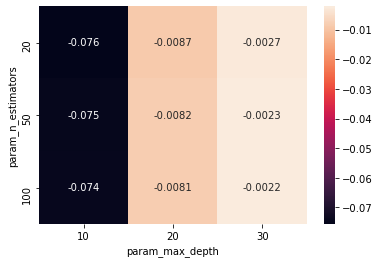

In [19]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_max_depth = results['param_max_depth']
param_min_samples_split = results['param_n_estimators']

data_train = results.pivot('param_n_estimators', 'param_max_depth', 'mean_train_score')
sns.heatmap(data_train, annot=True)

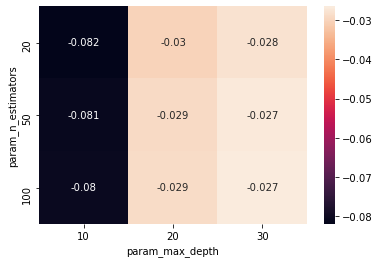

In [20]:
data_test = results.pivot('param_n_estimators', 'param_max_depth', 'mean_test_score')
sns.heatmap(data_test, annot=True)

In [180]:
lin_reg = RandomForestRegressor(max_depth = 20, n_estimators = 50, verbose=1, n_jobs = 3, max_features=0.5)
lin_reg.fit(X_train_select, np.log1p(y_train))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=50, n_jobs=3,
                      verbose=1)

In [181]:
y_train_pred = lin_reg.predict(X_train_select)
y_valid_pred = lin_reg.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


0.10610690642304652
0.13675473210090142


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.3s finished


In [90]:
## Using Custom imputer ##
lin_reg = RandomForestRegressor(max_depth = 20, n_estimators = 50, verbose=1, n_jobs = 3, max_features=0.5)
lin_reg.fit(X_train_select, np.log1p(y_train))

y_train_pred = lin_reg.predict(X_train_select)
y_valid_pred = lin_reg.predict(X_valid_select)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


0.10637128875031282
0.13768622682422385


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.3s finished


**XGBoost**

In [15]:
xgb_reg=xgb.XGBRegressor()

prams={
    'learning_rate':[0.03,0.05,0.1],
     'n_estimators':[500,2000,4000],
     'max_depth':[5,7,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
tscv = TimeSeriesSplit(n_splits=3)
random_cfl=RandomizedSearchCV(xgb_reg, param_distributions=prams,verbose=1,n_jobs=3, cv = tscv, n_iter=10)
random_cfl.fit(X_train_select, np.log1p(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 132.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample

In [16]:
random_cfl.best_params_

{'subsample': 0.5,
 'n_estimators': 2000,
 'max_depth': 10,
 'learning_rate': 0.05,
 'colsample_bytree': 0.3}

In [64]:
params = {"objective": "reg:squarederror", 
          "eta": 0.05,  
          "max_depth": 10,
          "subsample": 0.5,
          "colsample_bytree": 0.3,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 3000

dtrain = xgb.DMatrix(X_train_select, np.log1p(y_train))
dvalid = xgb.DMatrix(X_valid_select, np.log1p(y_valid))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 50, feval=rmspe_xg_log, verbose_eval=True)

[09:23:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.85590	eval-rmse:7.86264	train-rmspe:0.99974	eval-rmspe:0.99975
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:7.46399	eval-rmse:7.47126	train-rmspe:0.99954	eval-rmspe:0.99954
[2]	train-rmse:7.09190	eval-rmse:7.09854	train-rmspe:0.99925	eval-rmspe:0.99926
[3]	train-rmse:6.73832	eval-rmse:6.74390	train-rmspe:0.99887	eval-rmspe:0.99888
[4]	train-rmse:6.40250	eval-rmse:6.40788	train-rmspe:0.99835	eval-rmspe:0.99836
[5]	train-rmse:6.08342	eval-rmse:6.08881	train-rmspe:0.99767	eval-rmspe:0.99769
[6]	train-rmse:5.78053	eval-rmse:5.78604	

In [66]:
params = {"objective": "reg:squarederror", 
          "eta": 0.05,  
          "max_depth": 10,
          "subsample": 0.5,
          "colsample_bytree": 0.3,
          "silent": 1,
          "seed": 10   #
          }
num_boost_round = 2500

dtrain = xgb.DMatrix(X_train_full_select, np.log1p(y_train_full))
model = xgb.train(params, dtrain, num_boost_round)

[09:43:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [103]:
dtest = xgb.DMatrix(X_test_select.sort_values(['Month','Day','Store']))
y_test = model.predict(dtest)

In [125]:
test_sorted = test.sort_values(['Date','Store'])
result = pd.DataFrame({'Id': test_sorted['Id'], 'Sales': test_sorted['Open']*np.expm1(y_test)}).sort_values('Id')
#result.to_csv("submission_xgb.csv", index=False)

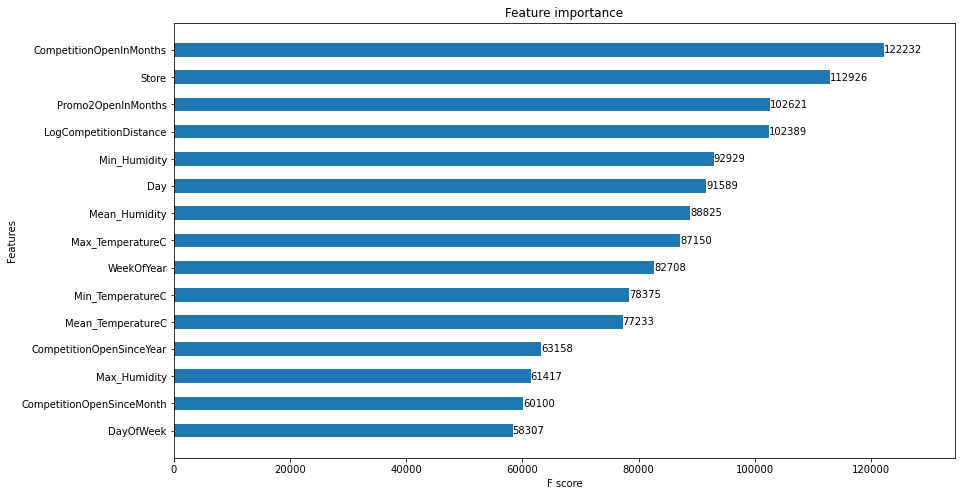

In [209]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(14,8))
xgb.plot_importance(model, max_num_features= 15, height=0.5, ax=ax, grid= False)
plt.show()

In [11]:
#Missing values
df[['Sales_30','Sales_60','Sales_90','Sales_180','Sales_1year']].isna().sum()/len(df)*100

Sales_30        4.160158
Sales_60        8.320316
Sales_90       12.480474
Sales_180      24.960948
Sales_1year    50.615256
dtype: float64

In [49]:
print('##Correlation with sales##\n')
print(df['MA_15'].corr(df['Sales']))
print(df['MA_30'].corr(df['Sales']))
print(df['EWM_15'].corr(df['Sales']))
print(df['EWM_30'].corr(df['Sales']))
print(df['EWM_45'].corr(df['Sales']))

print('\n##Missing Values###\n')
print(df['MA_30'].isna().sum()/len(df))
print(df['EWM_45'].isna().sum()/len(df))
print(df['EWM_30'].isna().sum()/len(df))

##Correlation with sales##

0.7320093288592924
0.7496977088119873
0.7321115073897869
0.7498015673796579
0.7570541453475802

##Missing Values###

0.08181644064592516
0.1026172306406519
0.08181644064592516


In [ ]:
'''estimators = [
    ('DT', DecisionTreeRegressor(max_depth= 22)),
    ('RF', RandomForestRegressor(max_depth=25, max_features=0.5, n_estimators=50, random_state=42))
]
stack_reg = StackingRegressor(
        estimators=estimators,
        verbose = 1,
        cv=2,
        n_jobs= 4,
        final_estimator=xgb.XGBRegressor(subsample = 0.5,
                                     n_estimators = 2500,
                                     max_depth =  10,
                                     learning_rate =  0.05,
                                     colsample_bytree =  0.3,
                                     random_state=42,
                                     silent = False)
    )
stack_reg.fit(X_train_full_select, np.log1p(y_train_full))'''

<h2>Assumptions</h2>

1. The summer hoildays or summer vacation in Germany mostly last for six to six and a half weeks. Making use of this assumption we have taken a constant window of 40 days (different for each state) which has been calculated based on starting and ending dates of the largest continuous school holidays.
2. For Promo2 we have been given only the months. So it is assumed that on all the days in that month, the store gives Promo2.

<h2>Features</h2>

1. Day of the month, Year, Month, Week of the year --> obtained from date
2. CompetitionOpenInMonths --> Competition Opened since (duration in month)
3. Promo2OpenInMonths --> Duration Promo2 is continuing for (duration in month)
4. IsPromoMonth --> If it is a month when a particular store is having promo2 (binary)
5. Sales_60, Sales_90, Sales_180, Sales_1year --> Sales lagged by these many days (Considered 60 days as minimum lag so that there is no missing value for the test set)
6. MA_15, MA_30 --> 15 and 30 day moving average for the 60 days lagged sales
7. EWM_15, EWM_30, EWM_45 --> Exponentially weighted moving average with window of 15, 30, 45 days on the 60days lagged data.
8. SchoolHolidaysInWeek/StateHolidaysInWeek --> Number of school/state holidays in that week
9. SchoolHolidaysInPrevWeek/StateHolidaysInPrevWeek --> Number of school/state holidays in last 7 days
10. SchoolHolidaysInNextWeek/StateHolidaysInNextWeek --> Number of school/state holidays in next 7 days
11. SchoolHolidaysInPrevWeek/StateHolidaysInPrevWeek --> Number of school/state holidays in last 7 days
12. SummerHoliday --> If a day is during summer holidays. Basically summer holidays are like summer vacations.
13. State --> Which store belongs to which state
14. 'Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State' --> Weather features corresponding to corresponding to states for each day.

<h2>Steps for Modelling</h2>

1. Imputed the missing values using Model based imputations. Used IterativeImputer in sklearn to compute the missing values. Took all the dependent variables except sales and date for this process.
2. Selected handful of columns for building the models. Experimented with combinations of columns and selected only those that gave the best scores consistently.
3. Built 3 models:<br>
    a. Decision Tree Regressor<br>
    b. Random Forest Regressor<br>
    c. XGBRegressor<br>
4. For each of these models did the hyperparameter tuning to get the best set of parameters to use for the final prediction model. Validated the initial models with 6 weeks hold out data to check the model performance befor building the final model with full training data.
5. For cross validation RandomizedSearchCV/GridSearchCV has been used with 3 fold TimeSeriesSplit which splits the dataset taking into account the temporal manner rather than randomly.
6. Below are the best hyperparameters and performance metrics for the models:<br>
   **Decision tree**<br>
   1. *Hyperparameters* <br>
       1. max_depth ==> 30<br>
       2. min_sample_split ==> 100 <br>
   2. *Performance Metrics* <br>
       1. Train RMSPE ==> 0.169<br>
       2. Valid RMSPE ==> 0.163<br>
   
   **Random Forest**<br>
   1. *Hyperparameters* <br>
       1. max_depth ==> 30<br>
       2. n_estimators ==> 50<br>
       3. max_features ==>0.5<br>
   2. *Performance Metrics* <br>
       1. Train RMSPE ==> 0.1061<br>
       2. Valid RMSPE ==> 0.1367<br>
          
   **XGB Regressor**<br>
   1. *Hyperparameters* <br>
       1. subsample ==> 0.5<br>
       2. n_estimators ==> 2000<br>
       3. max_depth ==> 10<br>
       4. learning_rate ==> 0.05<br>
       5. colsample_bytree ==> 0.3<br>
   2. *Performance Metrics* <br>
       1. Train RMSPE ==> 0.08002<br>
       2. Valid RMSPE ==> 0.1169<br>

<h2>Observation</h2>

1. For both RF and XGB column sampling rate is very crucial. That is, taking all the coilumns for all the trees does not give good performance.
2. Upon adding previous sales and moving average features to the data deteriorates the model performance to a large extent. So they have not been used in the final model.
3. Log transformation of Competition distance and Sales work better than using them as it is.